In [18]:
from google.colab import drive
drive.mount('/content/drive')
import warnings

# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%reload_ext autoreload
%autoreload 2

import gc
import random

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, metrics, impute, ensemble
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt

#autres librairies
import missingno as msno

Chargement du jeu de données

In [20]:
import pandas as pd
import sqlite3

# Spécifiez le chemin de votre fichier olist.db dans votre Google Drive
db_path = '/content/drive/MyDrive/openclass/olist.db'

In [21]:
# Connexion à la base de données SQLite
conn = sqlite3.connect(db_path)

# Chargez les données de la table souhaitée dans un DataFrame
query = "SELECT * FROM nom_de_votre_table"

# Lecture des noms de table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)

# Affichage des noms de table
print(tables)


            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


# Exploration

Transformation des tables en fichiers csv

In [22]:
import sqlite3
import pandas as pd

# Connexion à la base de données SQLite
conn = sqlite3.connect(db_path)

# Récupération des noms de table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)

# Export des tables en fichiers CSV
for table in tables['name']:
    # Lecture des données de la table dans un DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    # Export du DataFrame en fichier CSV avec le chemin spécifié
    df.to_csv(f"/content/drive/MyDrive/openclass/{table}.csv", index=False)

# Fermeture de la connexion à la base de données
conn.close()


On importe les fichiers csv

In [23]:
import pandas as pd

# Chemin du répertoire contenant les fichiers CSV
directory = "/content/drive/MyDrive/openclass/"

#On importe nos fichiers csv
 # Chemins vers les fichiers CSV
customers_file = "/content/drive/MyDrive/openclass/customers.csv"
geoloc_file = "/content/drive/MyDrive/openclass/geoloc.csv"
order_items_file = "/content/drive/MyDrive/openclass/order_items.csv"
order_pymts_file = "/content/drive/MyDrive/openclass/order_pymts.csv"
order_reviews_file = "/content/drive/MyDrive/openclass/order_reviews.csv"
orders_file = "/content/drive/MyDrive/openclass/orders.csv"
products_file = "/content/drive/MyDrive/openclass/products.csv"
sellers_file = "/content/drive/MyDrive/openclass/sellers.csv"
translation_file = "/content/drive/MyDrive/openclass/translation.csv"

# Importer les fichiers CSV en DataFrames
customers = pd.read_csv(customers_file)
geoloc = pd.read_csv(geoloc_file)
order_items = pd.read_csv(order_items_file)
order_pymts = pd.read_csv(order_pymts_file)
order_reviews = pd.read_csv(order_reviews_file)
orders = pd.read_csv(orders_file)
products = pd.read_csv(products_file)
sellers = pd.read_csv(sellers_file)
translation = pd.read_csv(translation_file)

# Dictionnaire pour stocker les DataFrames importés
dataframes = {}

# Afficher un aperçu des DataFrames importés
for name, df in dataframes.items():
    print(f"Aperçu du DataFrame : {name}")
    print(df.head())
    print("\n")


Création d'un Dataframe englobant tout les dataframe

In [24]:
# Réaliser les jointures avec des suffixes uniques pour éviter les conflits de noms de colonnes
merged_df = pd.merge(customers, orders, on='customer_id', suffixes=('_cust', '_order'))
merged_df = pd.merge(merged_df, order_items, on='order_id', suffixes=('_merged_items', '_items'))
merged_df = pd.merge(merged_df, order_reviews, on='order_id', suffixes=('_merged_reviews', '_reviews'))
merged_df = pd.merge(merged_df, order_pymts, on='order_id', suffixes=('_merged_pymts', '_payments'))
merged_df = pd.merge(merged_df, products, on='product_id', suffixes=('_merged_products', '_products'))
merged_df = pd.merge(merged_df, sellers, on='seller_id', suffixes=('_merged_sellers', '_sellers'))
merged_df = pd.merge(merged_df, translation, on='product_category_name', suffixes=('_merged_translation', '_translation'))

# Aperçu du DataFrame fusionné
merged_df


,index_cust,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_order,order_id,order_status,order_purchase_timestamp,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_merged_translation,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88492,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,8683.0,54.0,64.0,31.0,1182,8577,itaquaquecetuba,SP,30,office_furniture
1,6177,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,60047,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,8683.0,54.0,64.0,31.0,1182,8577,itaquaquecetuba,SP,30,office_furniture
2,6177,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,60047,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,8683.0,54.0,64.0,31.0,1182,8577,itaquaquecetuba,SP,30,office_furniture
3,16036,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,42931,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,...,8683.0,54.0,64.0,31.0,1182,8577,itaquaquecetuba,SP,30,office_furniture
4,19847,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,32077,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,...,8683.0,54.0,64.0,31.0,1182,8577,itaquaquecetuba,SP,30,office_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,45025,0fbd856ba1d4961786fb54bd448eb7fe,96328ac15f58fbb232fe14b182103382,89675,vargem bonita,SC,59073,937592924b66482b823ee7ecd185d0ff,delivered,2018-03-31 19:17:43,...,12500.0,83.0,21.0,43.0,344,89701,concordia,SC,60,la_cuisine
115605,46598,98a1b4f80dd0ccb7d1ae5a75ba5c904e,bf5ed75fca98e8f79c49e9a5bf7690e1,13480,limeira,SP,42587,28915ae2a90c218f0c2b7f8e0fb280e0,delivered,2017-04-09 20:04:37,...,450.0,31.0,10.0,18.0,344,89701,concordia,SC,60,la_cuisine
115606,55058,aa0533eb31ed3be79086f11bb2bec430,a490d5875edefe9bb8f5101ec2f6b56f,13870,sao joao da boa vista,SP,4272,e22a3e8048469ea68906f666d446c25c,delivered,2017-08-28 09:48:01,...,2200.0,84.0,12.0,15.0,344,89701,concordia,SC,60,la_cuisine
115607,65274,d11524bb77c28efad04e4467eac8a660,6968d41eb700f1ea39424e04b854bf7e,30130,belo horizonte,MG,98342,1ce0acf125f1bcd636276dd213363196,delivered,2017-07-31 18:10:29,...,2700.0,85.0,7.0,40.0,344,89701,concordia,SC,60,la_cuisine


In [25]:
# Suppression des variables index_x et index_y sans inplace=True
merged_df = merged_df.drop(['index_cust'], axis=1)

# Aperçu du DataFrame fusionné après suppression
print(merged_df)

                             customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2       8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
3       f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
4       6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   
...                                  ...                               ...   
115604  0fbd856ba1d4961786fb54bd448eb7fe  96328ac15f58fbb232fe14b182103382   
115605  98a1b4f80dd0ccb7d1ae5a75ba5c904e  bf5ed75fca98e8f79c49e9a5bf7690e1   
115606  aa0533eb31ed3be79086f11bb2bec430  a490d5875edefe9bb8f5101ec2f6b56f   
115607  d11524bb77c28efad04e4467eac8a660  6968d41eb700f1ea39424e04b854bf7e   
115608  d11524bb77c28efad04e4467eac8a660  6968d41eb700f1ea39424e04b854bf7e   

        customer_zip_code_prefix          customer_city custome

# Analyse exploratoire

In [26]:
# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Informations sur le dataframe (types de données, valeurs manquantes, etc.)
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   index_order                    115609 non-null  int64  
 6   order_id                       115609 non-null  object 
 7   order_status                   115609 non-null  object 
 8   order_purchase_timestamp       115609 non-null  object 
 9   order_approved_at              115595 non-null  object 
 10  order_delivered_carrier_date   114414 non-null  object 
 11  order_delivered_customer_date  113209 non-null  object 
 12  order_estimated_delivery_date 

In [27]:
# Statistiques descriptives
merged_df.describe()

,customer_zip_code_prefix,index_order,index_merged_reviews,order_item_id,price,freight_value,index_reviews,review_score,index_merged_products,payment_sequential,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index_merged_translation,seller_zip_code_prefix,index_translation
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,...,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000
mean,35061.537597,49755.976645,56257.650823,1.194535,120.619850,20.056880,49584.724113,4.034409,51937.865062,1.093747,...,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,1519.720195,24515.713958,11.427986
std,29841.671732,28737.999835,32533.270289,0.685926,182.653476,15.836184,28652.557866,1.385584,29974.302448,0.729849,...,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,879.443982,27636.640968,12.416444
min,1003.000000,0.000000,0.000000,1.000000,0.850000,0.000000,0.000000,1.000000,0.000000,1.000000,...,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.000000,1001.000000,0.000000
25%,11310.000000,24836.000000,28099.000000,1.000000,39.900000,13.080000,24783.000000,4.000000,26008.000000,1.000000,...,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,727.000000,6429.000000,3.000000
50%,24241.000000,49744.000000,56192.000000,1.000000,74.900000,16.320000,49561.000000,5.000000,51941.000000,1.000000,...,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1522.000000,13660.000000,7.000000
75%,58745.000000,74695.000000,84462.000000,1.000000,134.900000,21.210000,74314.000000,5.000000,77852.000000,1.000000,...,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,2291.000000,28605.000000,16.000000
max,99980.000000,99440.000000,112649.000000,21.000000,6735.000000,409.680000,99223.000000,5.000000,103885.000000,29.000000,...,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,3094.000000,99730.000000,70.000000


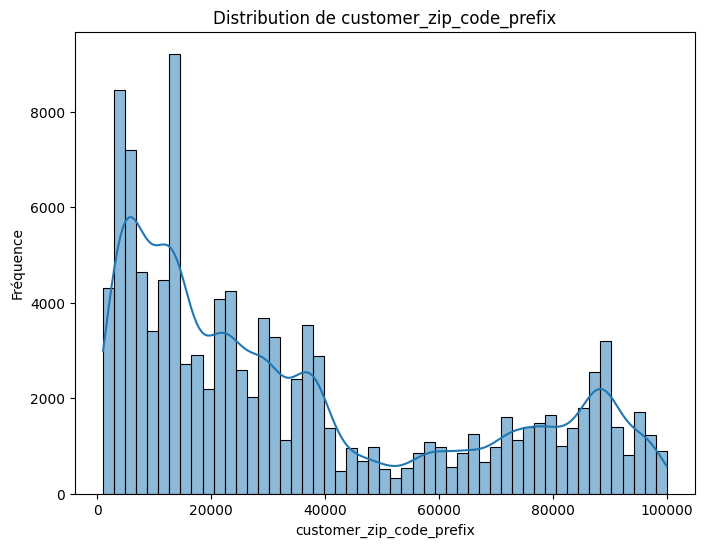

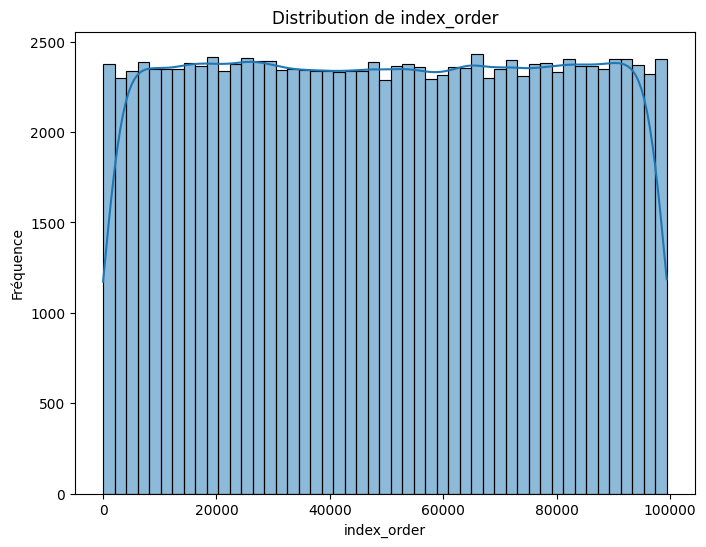

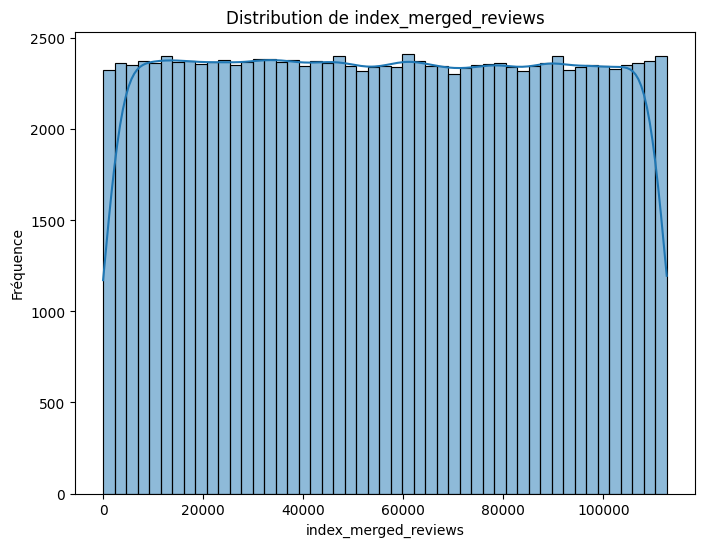

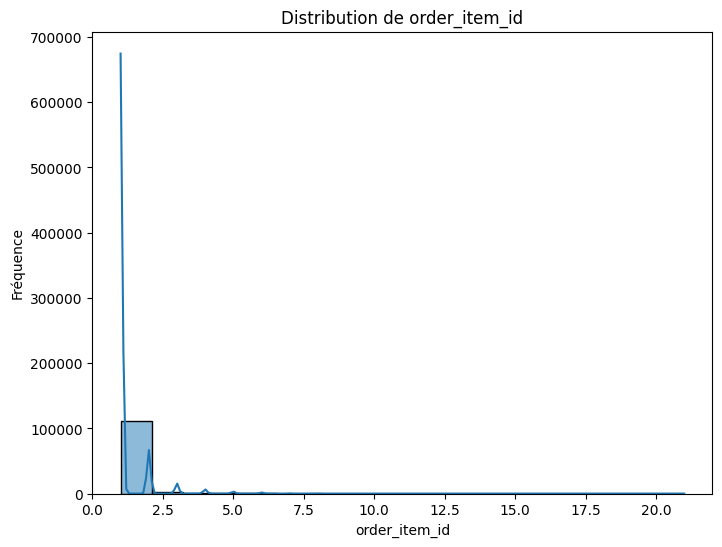

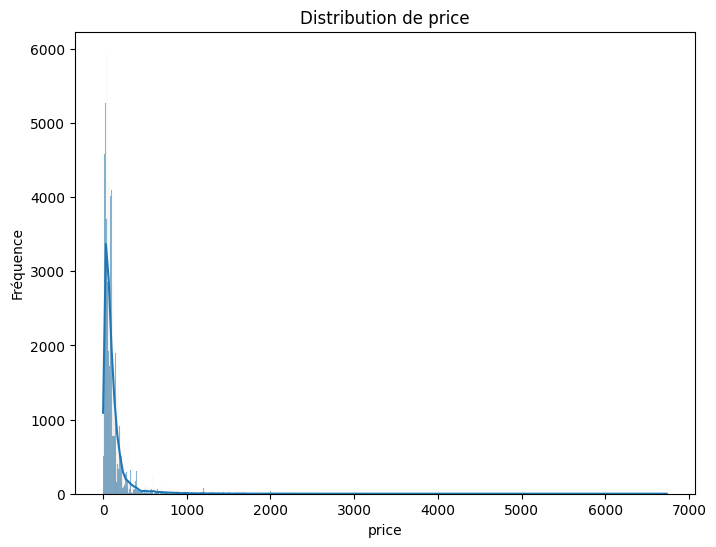

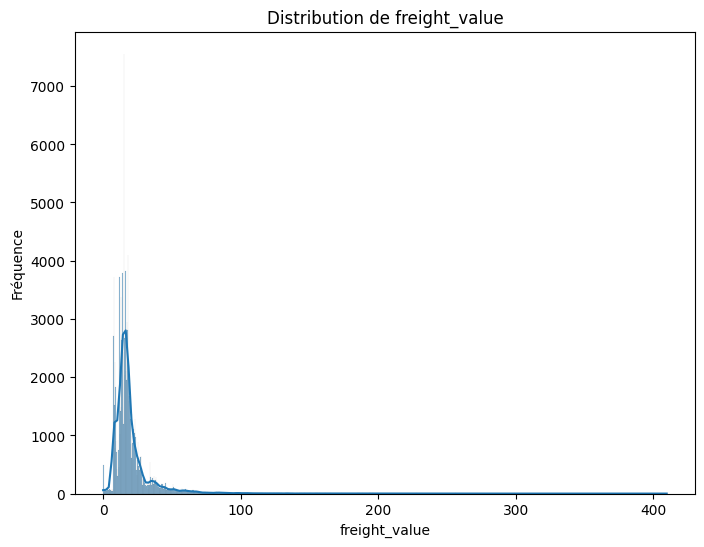

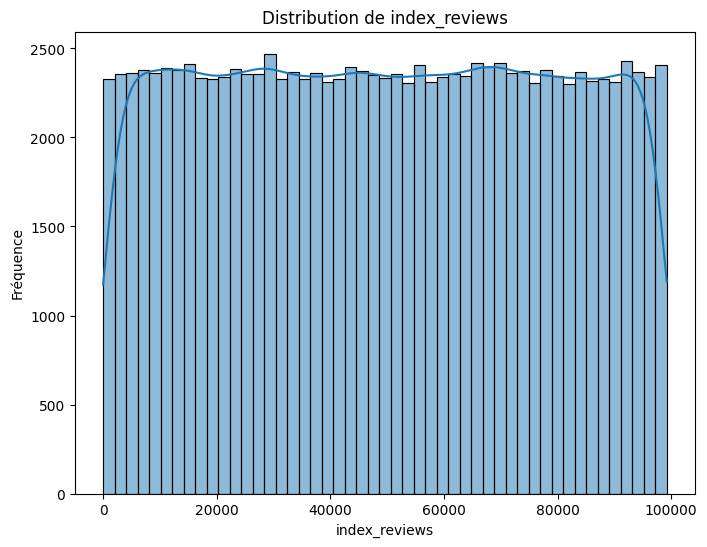

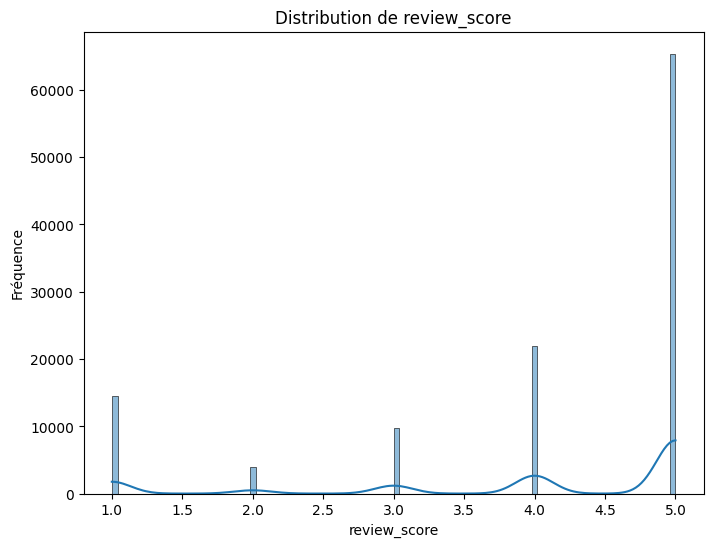

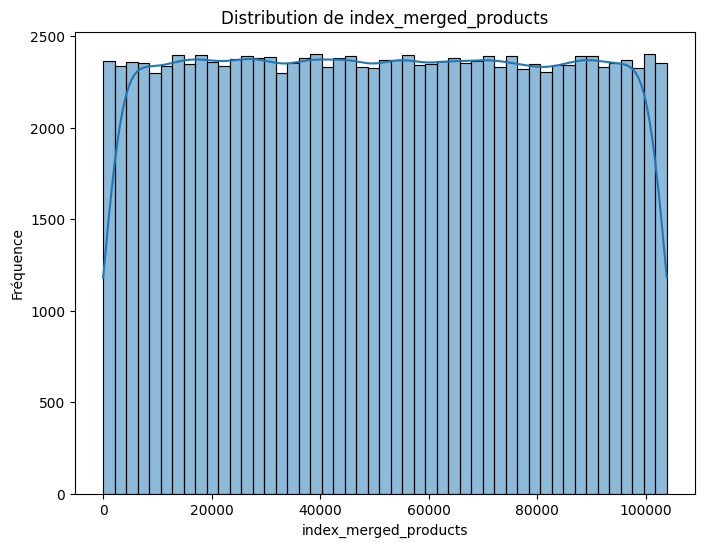

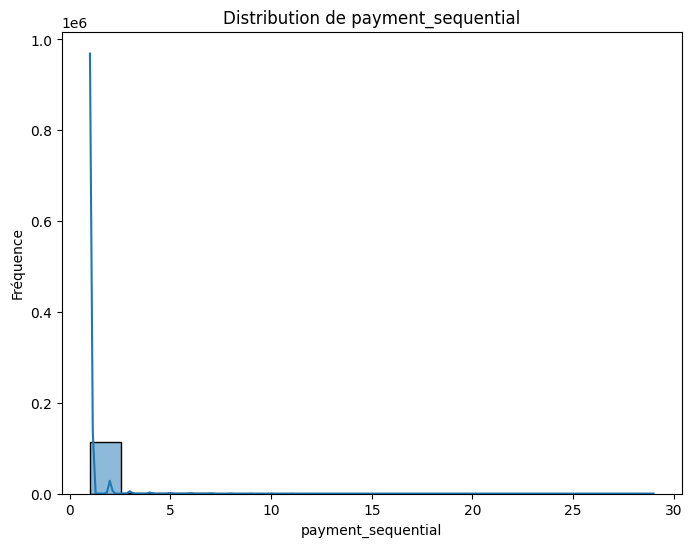

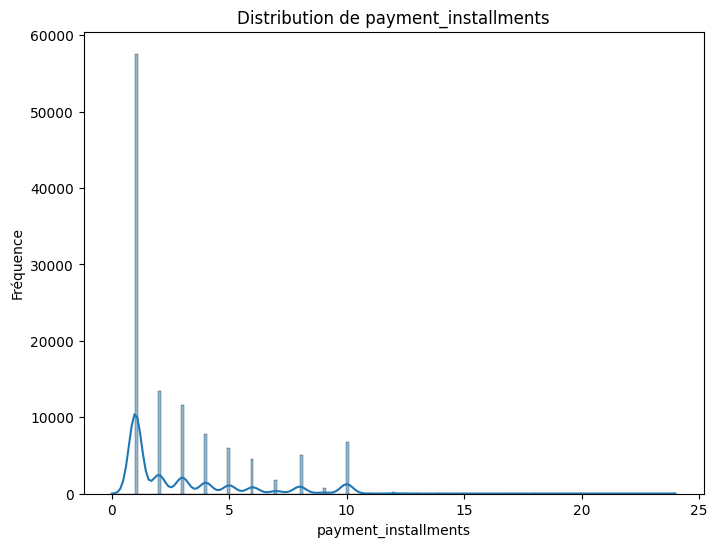

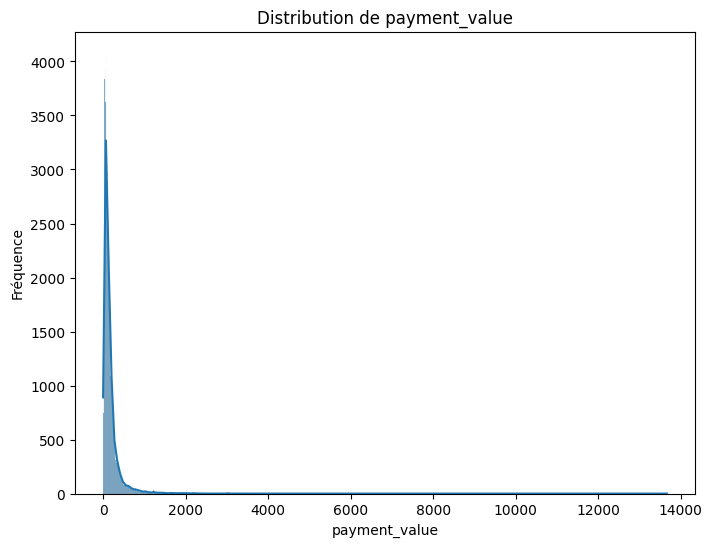

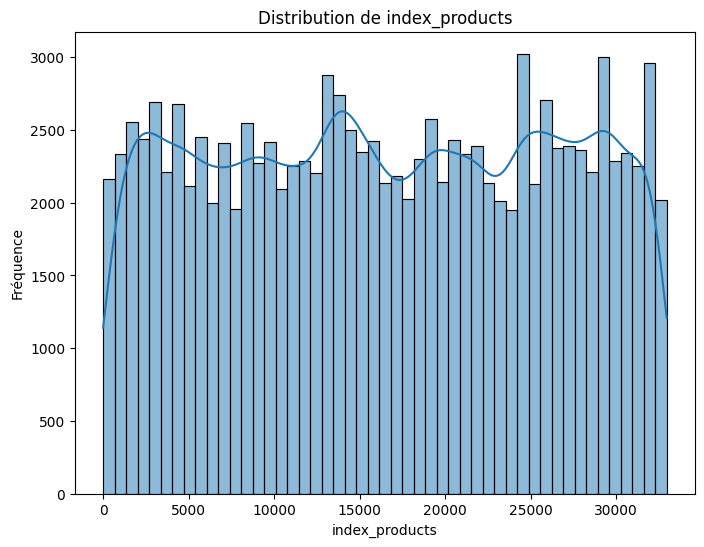

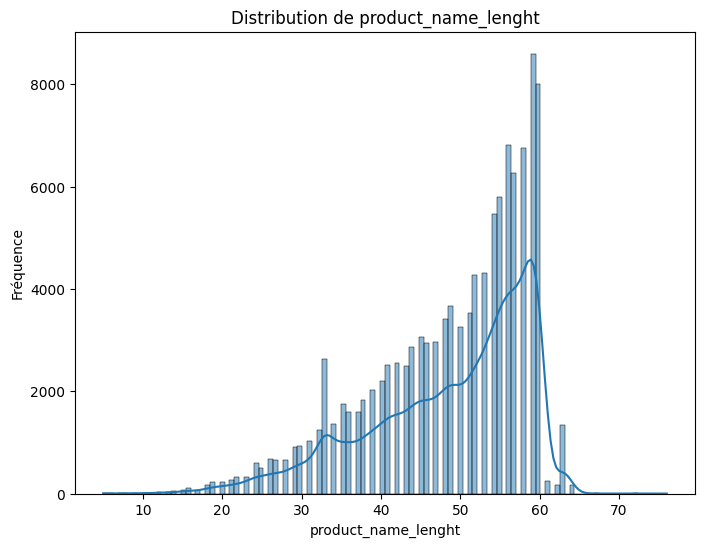

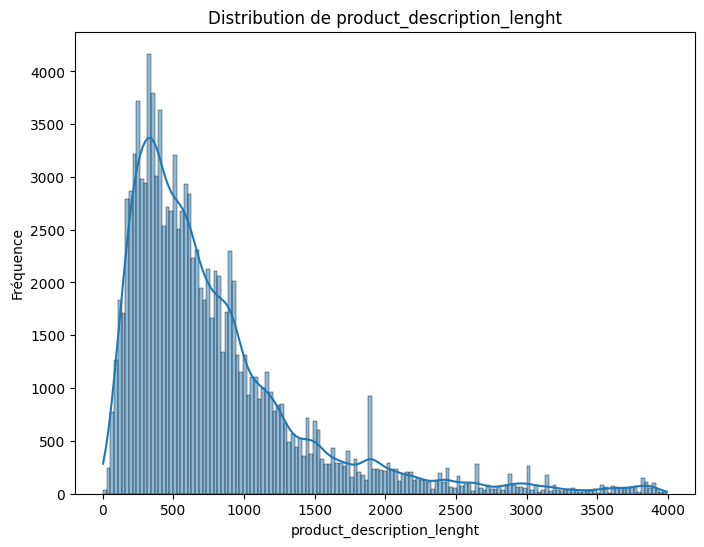

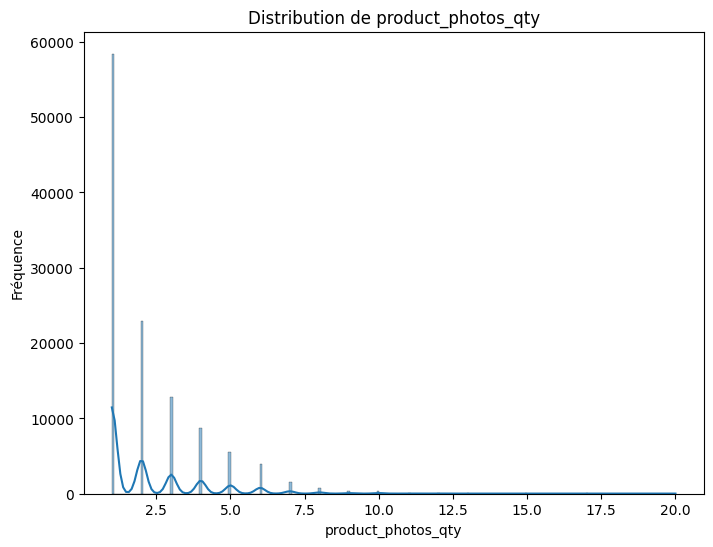

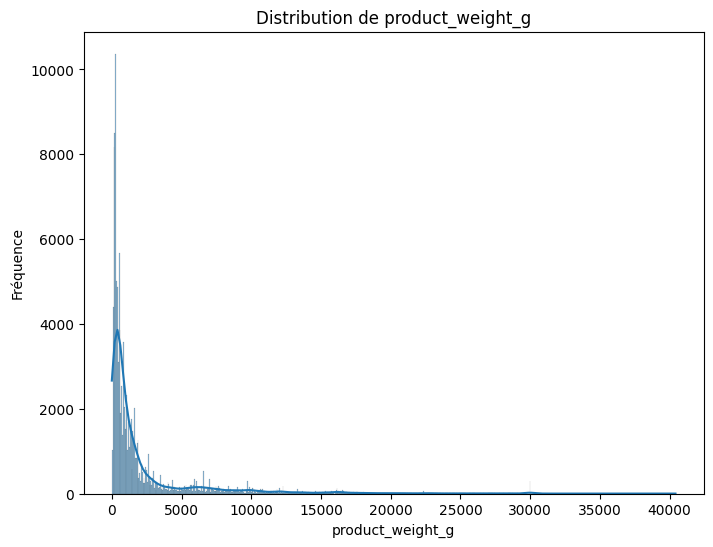

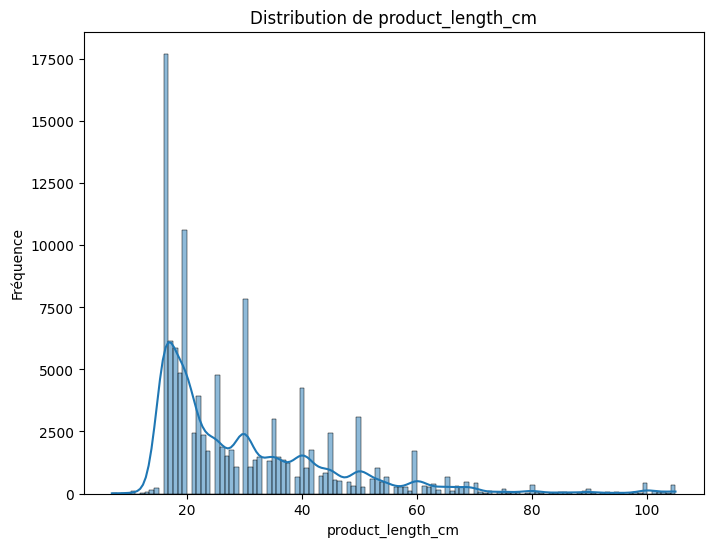

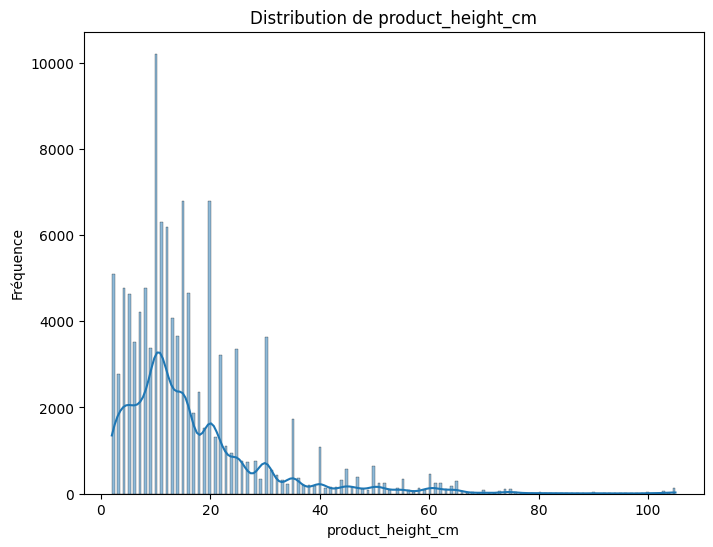

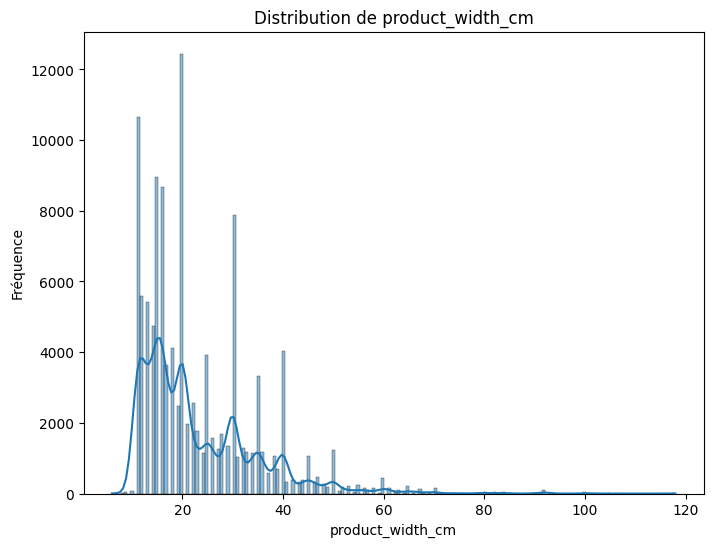

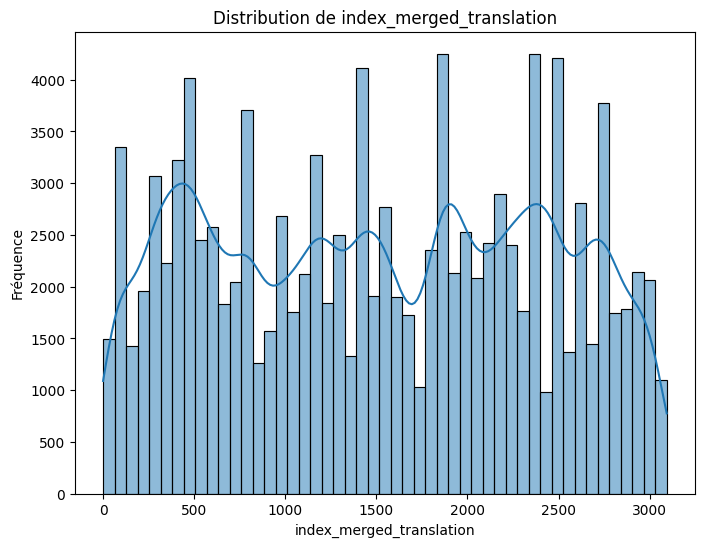

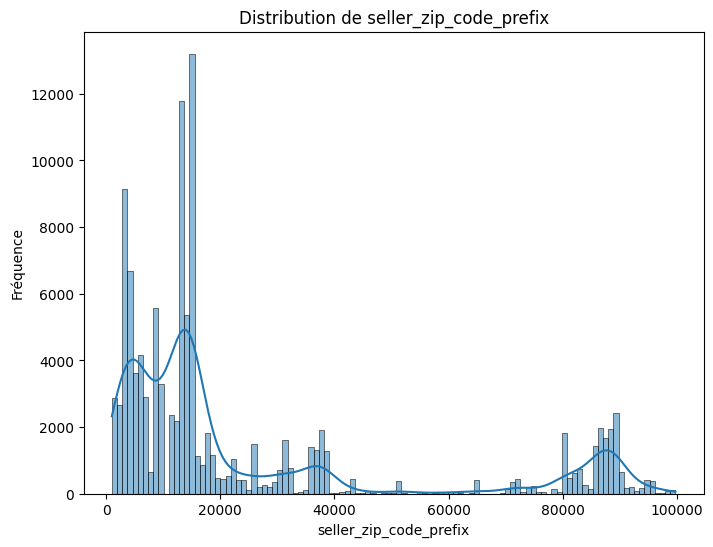

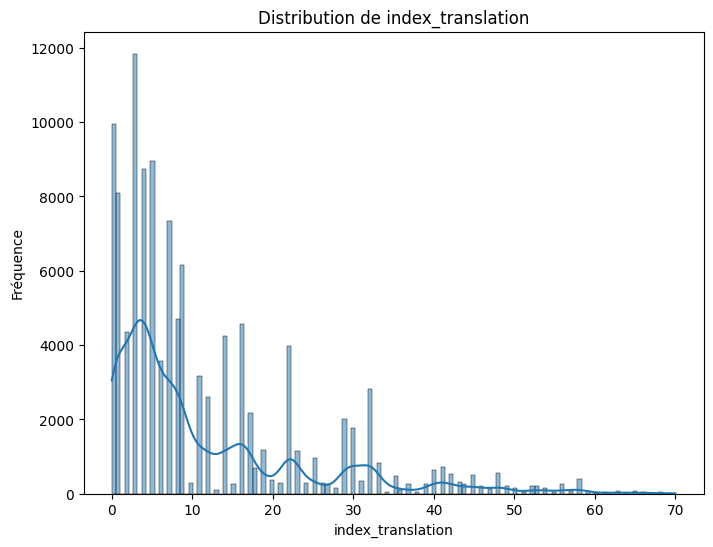

In [28]:
# Visualisation des distributions des variables numériques
numeric_cols = merged_df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(merged_df[col], kde=True)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.show()

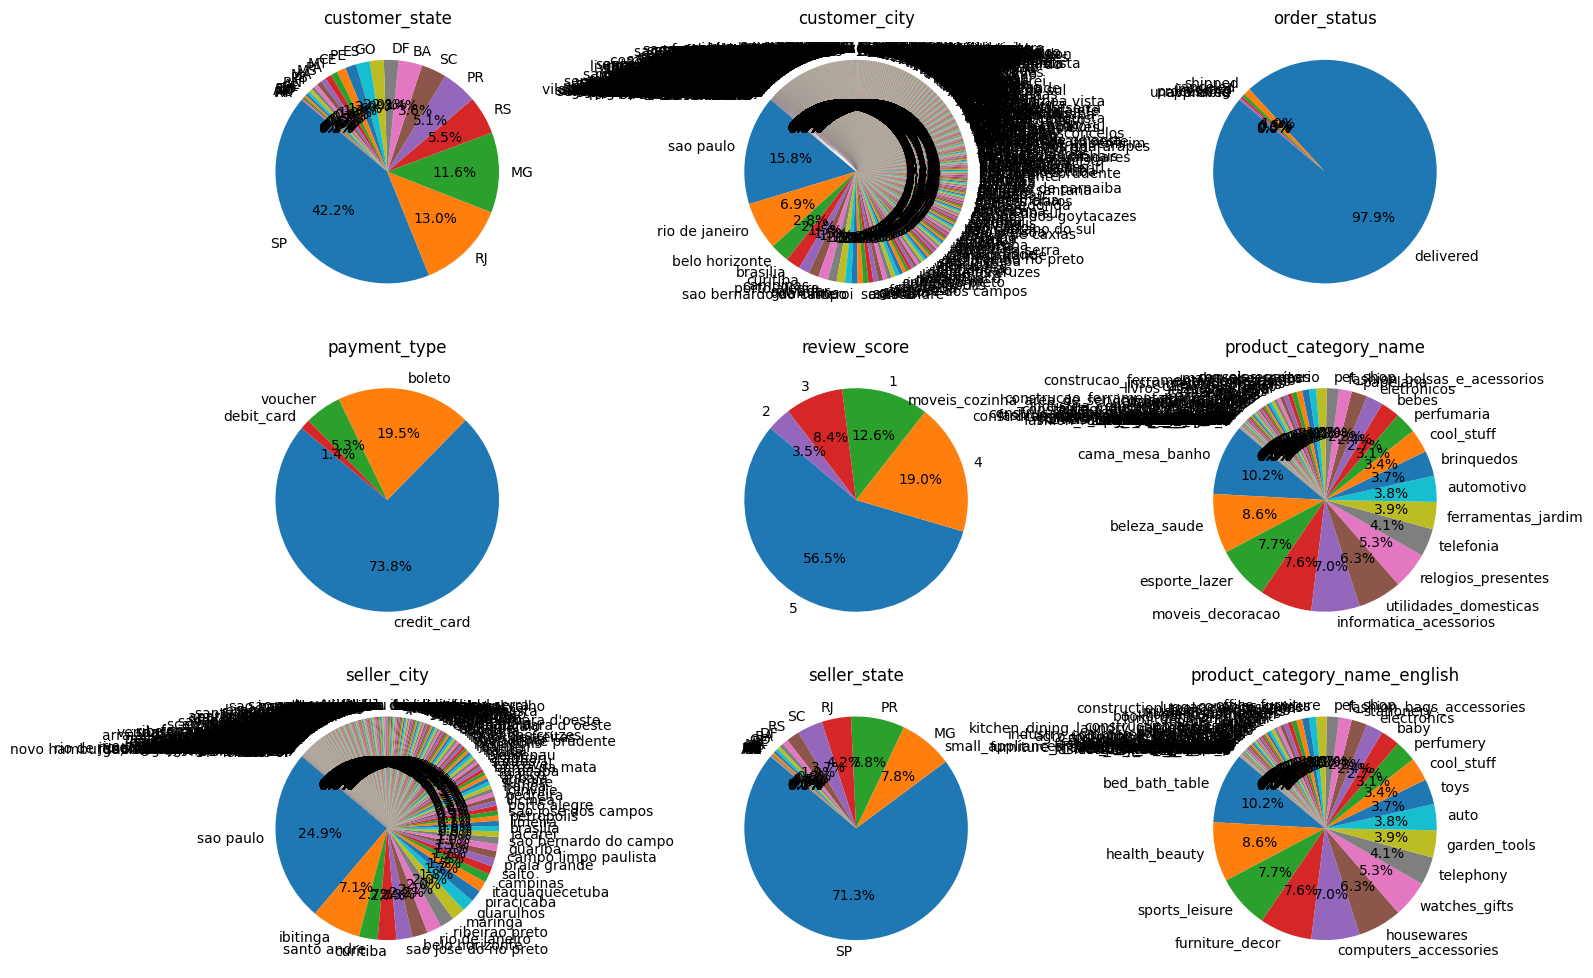

In [29]:
import matplotlib.pyplot as plt

# Liste des variables qualitatives
qualitative_cols = [
    'customer_state', 'customer_city', 'order_status', 'payment_type',
    'review_score', 'product_category_name', 'seller_city', 'seller_state',
    'product_category_name_english'
]

# Définition de la disposition des sous-graphiques
num_plots = len(qualitative_cols)
num_cols = 3
num_rows = (num_plots // num_cols) + (1 if num_plots % num_cols > 0 else 0)

# Création de sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Parcours des variables qualitatives et création des diagrammes camemberts
for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    counts = merged_df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(col)

# Suppression des axes pour une meilleure lisibilité
for ax in axes[num_plots:]:
    ax.remove()

plt.tight_layout()
plt.show()


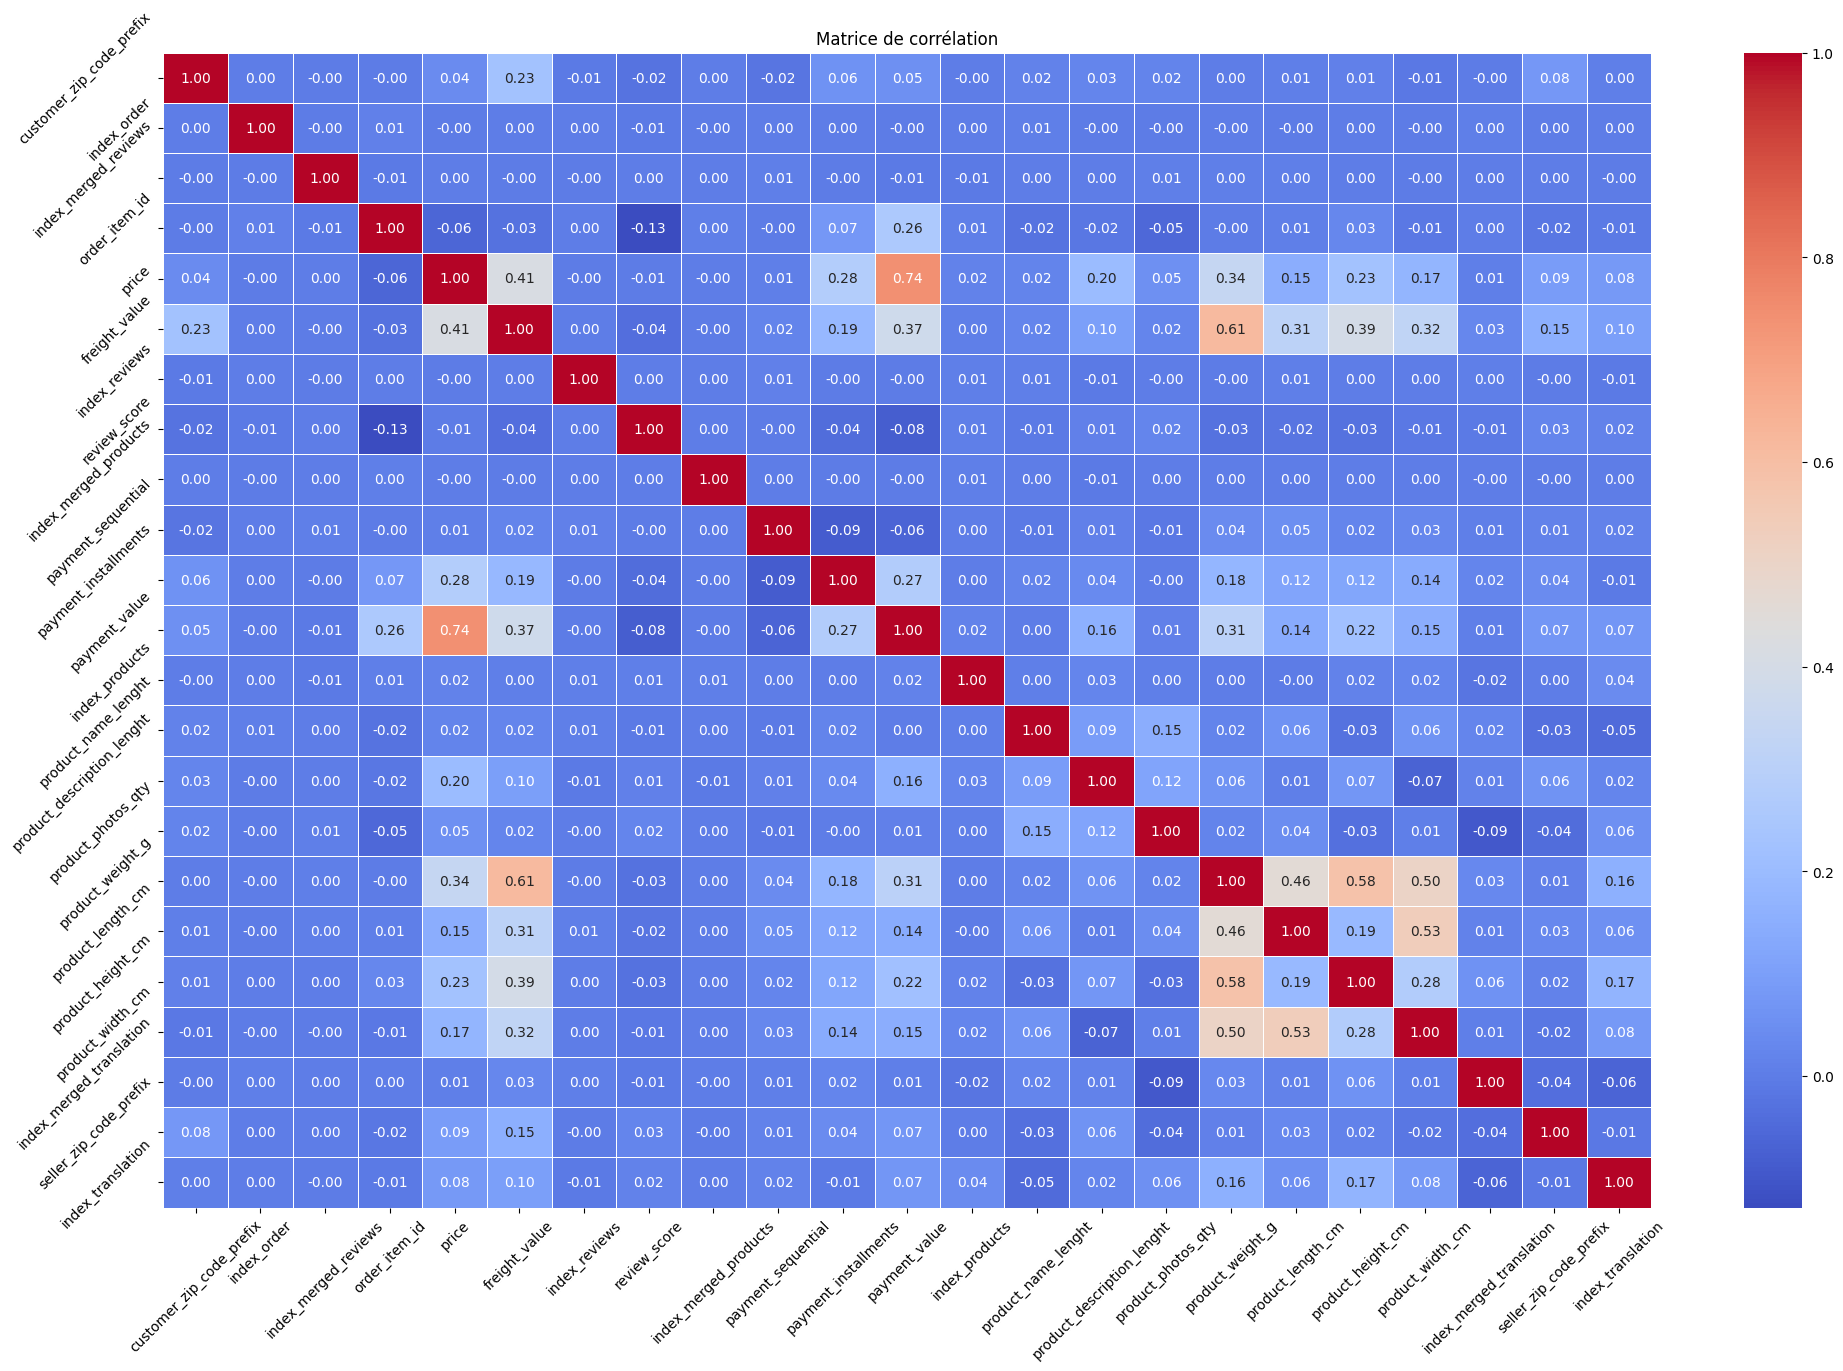

In [31]:
# Exclure les colonnes non numériques du DataFrame
numeric_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculer la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Afficher la heatmap de la matrice de corrélation
plt.figure(figsize=(24, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, linewidths=.5)
plt.title('Matrice de corrélation')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [32]:
# Sélection des paires de variables fortement corrélées avec une corrélation > 0.5
high_corr_pairs = correlation_matrix[(correlation_matrix.abs() > 0.5) & (correlation_matrix != 1.0)]
high_corr_pairs = high_corr_pairs.dropna(how='all', axis=1).dropna(how='all')

# Affichage des paires de variables fortement corrélées
print("Paires de variables ayant une corrélation > 0.5 :")
for col in high_corr_pairs.columns:
    correlated_with = high_corr_pairs[col].dropna().index.tolist()
    for c in correlated_with:
        if col != c:
            print(f"{col} - {c}")


Paires de variables ayant une corrélation > 0.5 :
price - payment_value
freight_value - product_weight_g
payment_value - price
product_weight_g - freight_value
product_weight_g - product_height_cm
product_weight_g - product_width_cm
product_length_cm - product_width_cm
product_height_cm - product_weight_g
product_width_cm - product_weight_g
product_width_cm - product_length_cm


In [33]:
#Suppression des variables freight_value product_height_cm product_width_cm
# Liste des variables à supprimer
variables_a_supprimer = [ 'freight_value', 'product_height_cm', 'product_width_cm']

# Suppression des variables
merged_df = merged_df.drop(variables_a_supprimer, axis=1)


Vérification de la présence de doublons

In [34]:
# Vérifier les doublons
duplicates = merged_df.duplicated()

# Vérifier s'il y a des doublons dans l'ensemble du DataFrame
if duplicates.any():
    print("Il y a des doublons dans le jeu de données.")
    # Afficher les lignes dupliquées
    duplicate_rows = merged_df[duplicates]
    print("Lignes dupliquées :")
    print(duplicate_rows)
else:
    print("Il n'y a pas de doublons dans le jeu de données.")

Il n'y a pas de doublons dans le jeu de données.


Valeurs manquantes

In [35]:
# Calcul du pourcentage de valeurs manquantes par variable
missing_percentage = merged_df.isna().mean() * 100

# Tri des pourcentages de valeurs manquantes en ordre décroissant
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# Affichage des pourcentages de valeurs manquantes par variable
print(missing_percentage_sorted)


review_comment_title             88.062348
review_comment_message           57.697065
order_delivered_customer_date     2.075963
order_delivered_carrier_date      1.033657
order_approved_at                 0.012110
product_length_cm                 0.000865
product_weight_g                  0.000865
index_translation                 0.000000
index_products                    0.000000
review_answer_timestamp           0.000000
index_merged_products             0.000000
payment_sequential                0.000000
payment_type                      0.000000
payment_installments              0.000000
payment_value                     0.000000
product_description_lenght        0.000000
product_category_name             0.000000
product_name_lenght               0.000000
seller_state                      0.000000
review_creation_date              0.000000
index_merged_translation          0.000000
seller_zip_code_prefix            0.000000
seller_city                       0.000000
product_pho

In [36]:
# Supprimer les variables avec plus de 50% de valeurs manquantes
merged_df = merged_df.dropna(thresh=len(merged_df) * 0.5, axis=1)


In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Créer un objet IterativeImputer
imputer = IterativeImputer(random_state=0)

# Sélectionner les variables à imputer
variables_to_impute = ['product_length_cm', 'product_weight_g']

# Fit et transform pour remplacer les valeurs manquantes dans merged_df
merged_df[variables_to_impute] = imputer.fit_transform(merged_df[variables_to_impute])


Variables non pertinentes au sens de notre étude

In [38]:
print(merged_df.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'index_order', 'order_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'index_merged_reviews',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'index_reviews', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp',
       'index_merged_products', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'index_products',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'index_merged_translation',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'index_translation', 'product_category_name_english'],
     

In [39]:
# Liste des variables non pertinentes à supprimer
variables_a_supprimer = ['product_description_lenght', 'product_name_lenght', 'review_creation_date', 'review_answer_timestamp','product_category_name']

# Suppression des variables
merged_df = merged_df.drop(variables_a_supprimer, axis=1)


# Découverte des variables

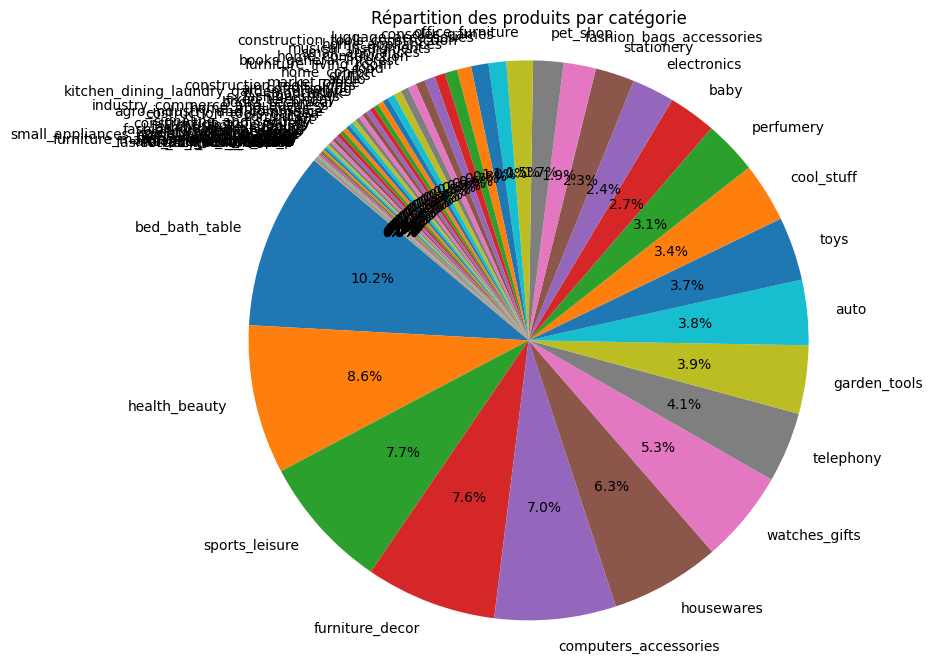

In [40]:
# Calcul de la répartition des produits par catégorie
repartition_categories = merged_df['product_category_name_english'].value_counts()

# Affichage du diagramme circulaire
plt.figure(figsize=(10, 8))
plt.pie(repartition_categories, labels=repartition_categories.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des produits par catégorie')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [41]:
#Valeurs possibles de order_status
merged_df['order_status'].unique().tolist()

['delivered',
 'shipped',
 'invoiced',
 'processing',
 'canceled',
 'unavailable',
 'approved']

Informations relatives aux clients

In [42]:
# Calculer le nombre de commandes pour chaque client unique
top_customers = merged_df['customer_unique_id'].value_counts()

# Afficher les 5 meilleurs clients avec le plus grand nombre de commandes
top_5_customers = top_customers.head(5)
print(top_5_customers)


customer_unique_id
9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
8af7ac63b2efbcbd88e5b11505e8098a    29
569aa12b73b5f7edeaa6f2a01603e381    26
Name: count, dtype: int64


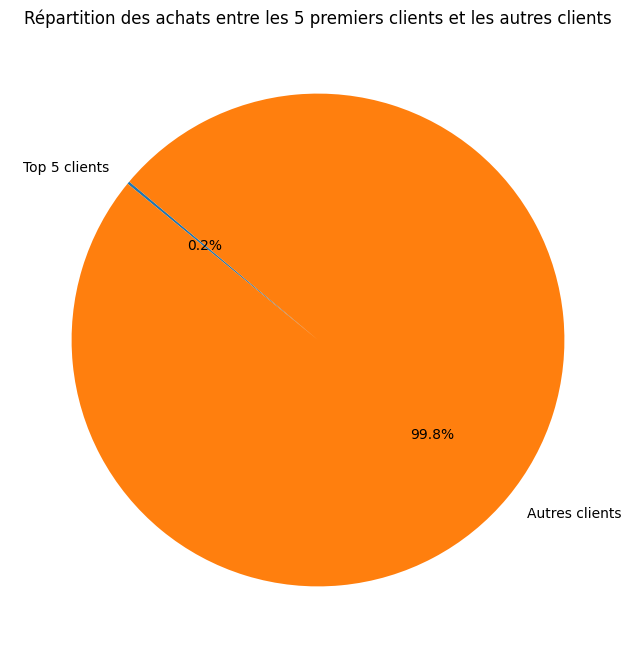

In [43]:
# top_customers est une Series contenant les compteurs de commandes pour chaque client unique
top_customers = merged_df['customer_unique_id'].value_counts()

# Sélectionner les 5 premiers clients
top_5_customers = top_customers.head(5)

# Calculer le nombre total d'achats pour les 5 premiers clients
total_achats_top_5 = top_5_customers.sum()

# Calculer le nombre total d'achats pour les autres clients
total_achats_autres = top_customers.sum() - total_achats_top_5

# Créer une liste contenant le nombre total d'achats pour les 5 premiers clients et pour les autres clients
total_achats = [total_achats_top_5, total_achats_autres]

# Créer une liste contenant les labels pour le diagramme circulaire
labels = ['Top 5 clients', 'Autres clients']

# Créer le diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(total_achats, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des achats entre les 5 premiers clients et les autres clients')
plt.show()

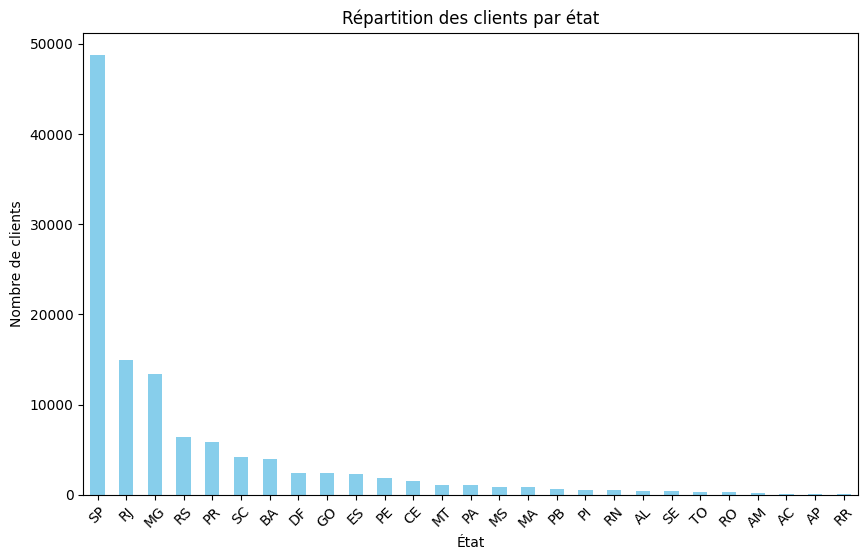

In [44]:
# Compter le nombre de clients par état
state_counts = merged_df['customer_state'].value_counts()

# Créer un graphique en barres
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.title('Répartition des clients par état')
plt.xlabel('État')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

# Afficher le graphique
plt.show()


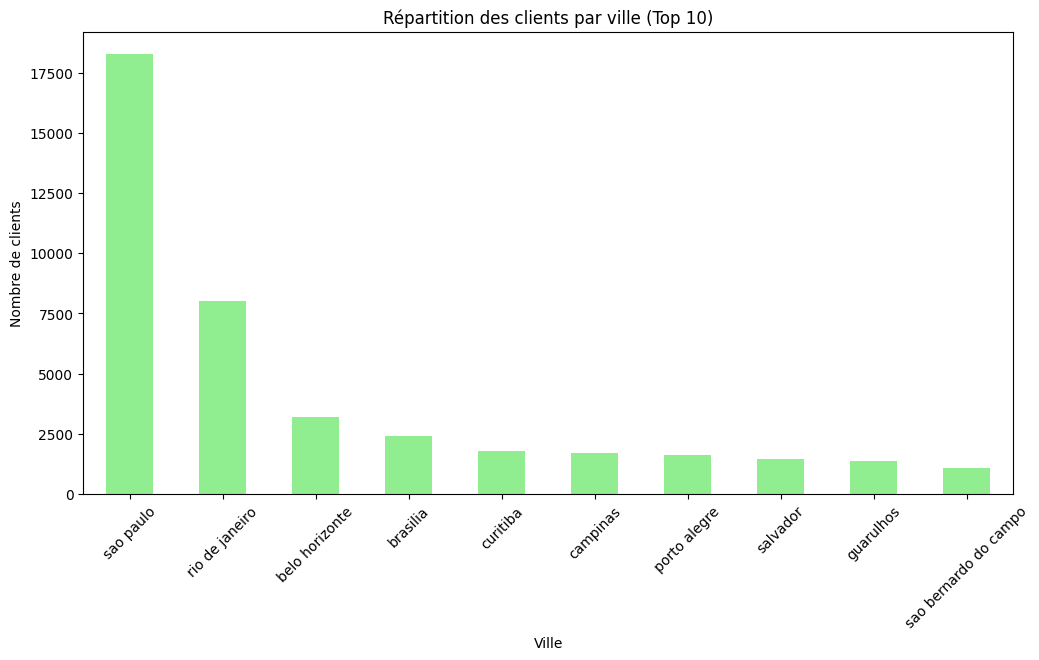

In [45]:
# Compter le nombre de clients par ville
city_counts = merged_df['customer_city'].value_counts()

# Sélection des 10 villes les plus fréquentes
top_cities = city_counts.head(10)

# Créer un graphique en barres
plt.figure(figsize=(12, 6))
top_cities.plot(kind='bar', color='lightgreen')

# Ajouter des étiquettes et un titre
plt.title('Répartition des clients par ville (Top 10)')
plt.xlabel('Ville')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

# Afficher le graphique
plt.show()


# Création de nouvelles varibales

In [46]:
# Calculer le nombre de commandes par client
commandes_par_clients = merged_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
commandes_par_clients.columns = ['customer_unique_id', 'commandes_par_clients']

# Fusionner avec le DataFrame merged_df
merged_df = pd.merge(merged_df, commandes_par_clients, on='customer_unique_id', how='left')


In [47]:
# Définir la colonne du montant de la commande
montant_commande = merged_df['price']

# Calculer le montant cumulé pour chaque client
merged_df['montant_cumule'] = merged_df.groupby('customer_unique_id')['price'].transform(pd.Series.cumsum)


In [48]:
# Trier le dataframe par date de commande (du plus récent au plus ancien)
df = merged_df.sort_values(by='order_purchase_timestamp', ascending=False)
# Afficher la date de la première ligne (commande la plus récente)
date_commande_plus_recente = df['order_purchase_timestamp'].iloc[0]
# Afficher la date
print(date_commande_plus_recente)


2018-09-03 09:06:57


In [49]:
#Durée depuis la dernière commande pour chaque client
# Convertir la colonne 'date_commande' en type datetime
date_commande = pd.to_datetime(merged_df['order_purchase_timestamp'])
# Définir la date d'aujourd'hui
date_today = pd.to_datetime('2018-09-03')
# Calculer la différence en jours entre la date d'aujourd'hui et la date de la dernière commande
merged_df['duree_depuis_derniere_commande'] = (date_today - date_commande).dt.days
merged_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,...,product_length_cm,index_merged_translation,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english,commandes_par_clients,montant_cumule,duree_depuis_derniere_commande
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88492,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,124.99,474
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,60047,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,112.99,297
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,60047,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,225.98,297
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,42931,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,124.99,483
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,32077,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,106.99,211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,0fbd856ba1d4961786fb54bd448eb7fe,96328ac15f58fbb232fe14b182103382,89675,vargem bonita,SC,59073,937592924b66482b823ee7ecd185d0ff,delivered,2018-03-31 19:17:43,2018-03-31 19:55:18,...,83.0,344,89701,concordia,SC,60,la_cuisine,1,389.00,155
115605,98a1b4f80dd0ccb7d1ae5a75ba5c904e,bf5ed75fca98e8f79c49e9a5bf7690e1,13480,limeira,SP,42587,28915ae2a90c218f0c2b7f8e0fb280e0,delivered,2017-04-09 20:04:37,2017-04-11 03:45:26,...,31.0,344,89701,concordia,SC,60,la_cuisine,1,36.99,511
115606,aa0533eb31ed3be79086f11bb2bec430,a490d5875edefe9bb8f5101ec2f6b56f,13870,sao joao da boa vista,SP,4272,e22a3e8048469ea68906f666d446c25c,delivered,2017-08-28 09:48:01,2017-08-28 10:05:04,...,84.0,344,89701,concordia,SC,60,la_cuisine,1,139.00,370
115607,d11524bb77c28efad04e4467eac8a660,6968d41eb700f1ea39424e04b854bf7e,30130,belo horizonte,MG,98342,1ce0acf125f1bcd636276dd213363196,delivered,2017-07-31 18:10:29,2017-07-31 18:25:20,...,85.0,344,89701,concordia,SC,60,la_cuisine,1,129.00,398


In [50]:
# Définition du chemin de destination du fichier CSV
csv_destination = "/content/drive/MyDrive/openclass/merged_df.csv"

# Export du DataFrame merged_df au format CSV
merged_df.to_csv(csv_destination, index=False)

# Confirmation de l'exportation
print("Le DataFrame a été exporté avec succès au format CSV.")


Le DataFrame a été exporté avec succès au format CSV.
